In [6]:
# Import modules

from music21 import corpus, instrument
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import itertools as iter
import re

from dimod import BinaryQuadraticModel
import dimod.generators
from dwave.samplers import SteepestDescentSolver
from dwave.system import DWaveSampler, EmbeddingComposite

from boundaryDetection import extractPhrases
from plotters import plotHistogram


# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = "beethoven/opus74.mxl"

score = corpus.parse("haydn/opus1no1/movement1.mxl")
identifier = "haydn_opus1no1_movement1"

score.write(fmt="musicxml", fp=f"../Pickles/{identifier}")

WindowsPath('c:/Users/Lucas/PHYS4213/Pickles/haydn_opus1no1_movement1.musicxml')

In [2]:
# Extract phrases from score

phrases = extractPhrases(score, 0.3, (0.3, 0.6))
pickle.dump(phrases, open(f"../Pickles/{identifier}_phrases.pkl", "wb"))

Creating phrases for Violin I part...
39 phrases created!
Creating phrases for Violin II part...
42 phrases created!
Creating phrases for Viola part...
31 phrases created!
Creating phrases for Cello part...
39 phrases created!


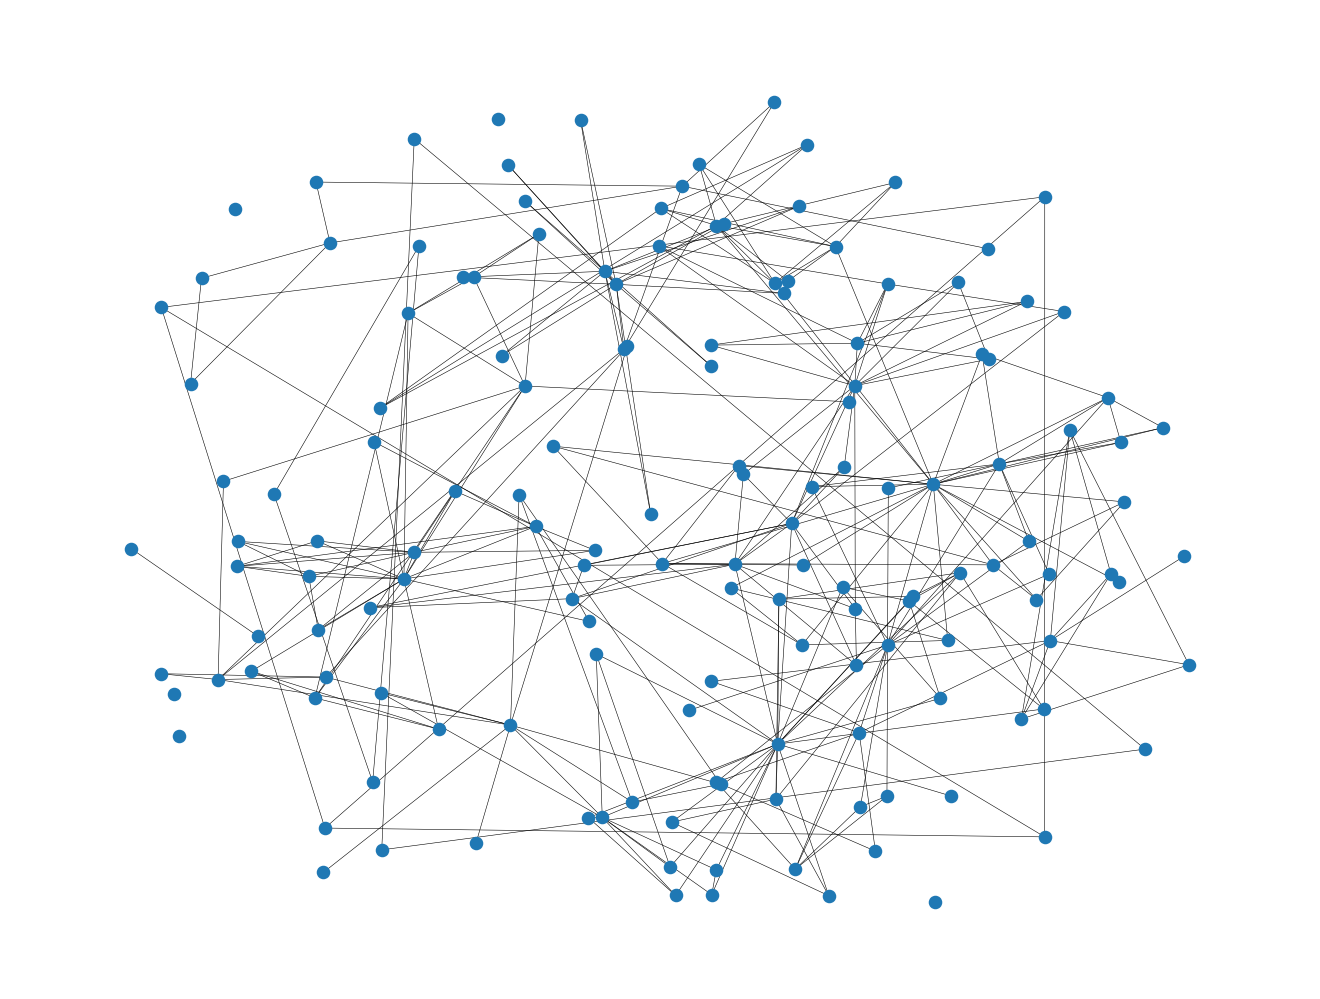

In [3]:
# Load created graph

G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw(G, pos=pos, node_size=15, width=0.2)

In [4]:
# Create colouring problem BQM

instruments = {"red":instrument.Flute, "green":instrument.Oboe, "blue":instrument.Bassoon}

bqm = BinaryQuadraticModel(vartype="BINARY")
allPhrases = [phrase for part in phrases for phrase in part]

# Add all vertices for each colour
bqm.add_variables_from([(f"{phrase.id}_{i}", 0)for phrase in allPhrases for i in instruments.keys()])

for phrase in allPhrases:
    # Each vertex coloured at most once
    bqm.add_linear_inequality_constraint([(f"{phrase.id}_{i}",1) for i in instruments.keys()], ub=1, lagrange_multiplier=10, label="One colour per vertex")
    # Maximise vertex weighting
    bqm.add_linear_from([(f"{phrase.id}_{i}", -phrase.entropy) for i in instruments.keys()])

for u, v, d in G.edges.data():
    # Adjacent vertices have different colours
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{i}", 100) for i in instruments.keys()])
    # Maximise edge weighting
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{j}", -d["weight"]) for i,j in iter.product(instruments.keys(), repeat=2)])

#pickle.dump(bqm, open(f"../Pickles/{identifier}_bqm.pkl", "wb"))

In [11]:
# Solve classically
df = SteepestDescentSolver().sample(bqm, num_reads=1000).to_pandas_dataframe(True) # Try more than one, simulated annealing
# Compare energies from different methods
# Just because it doesn't crash doesn't mean it passed
#pickle.dump(df, open(f"../Pickles/{identifier}_df.pkl", "wb"))

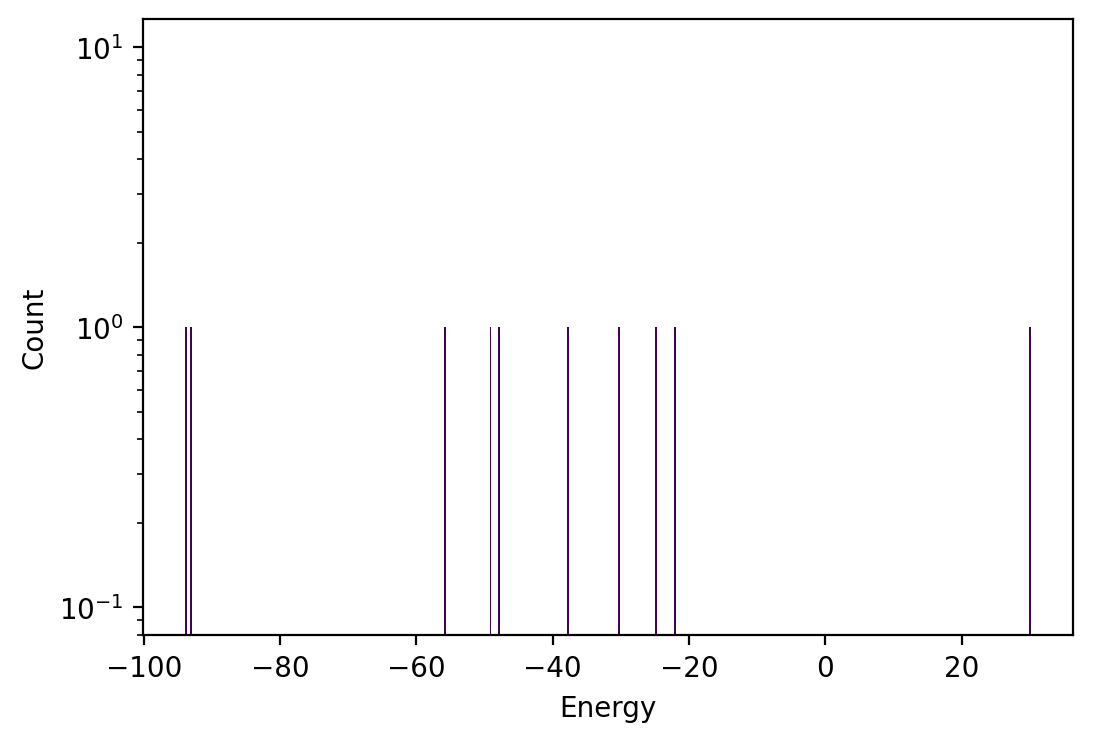

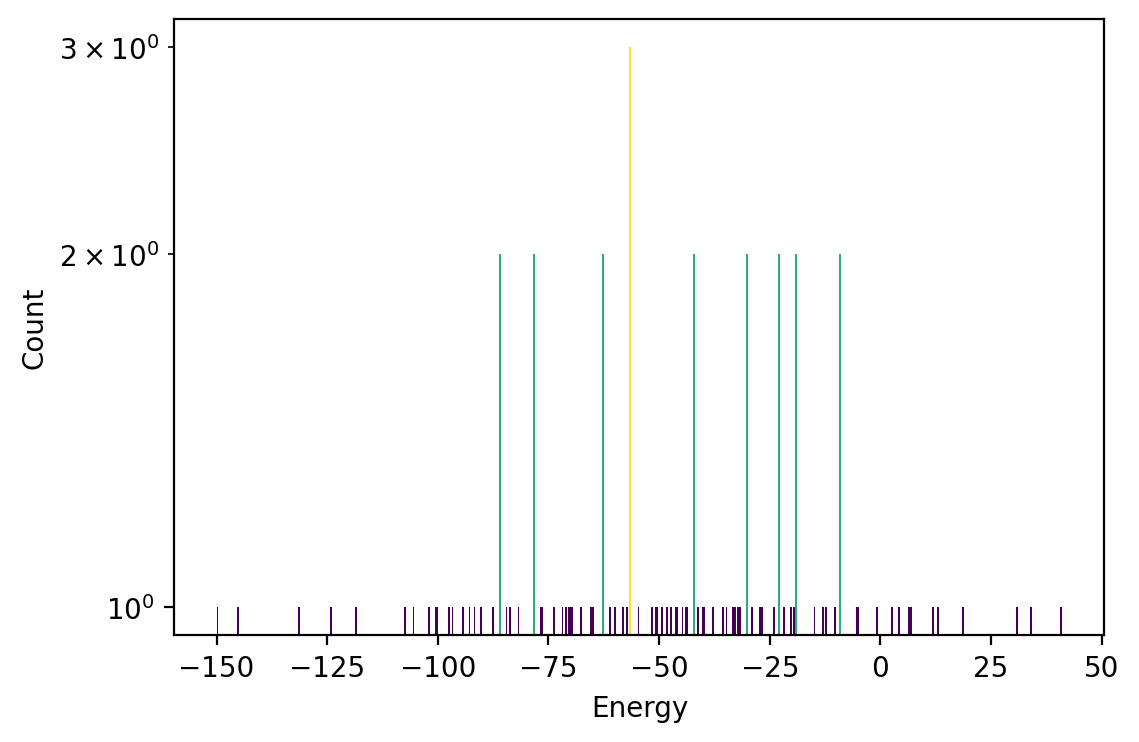

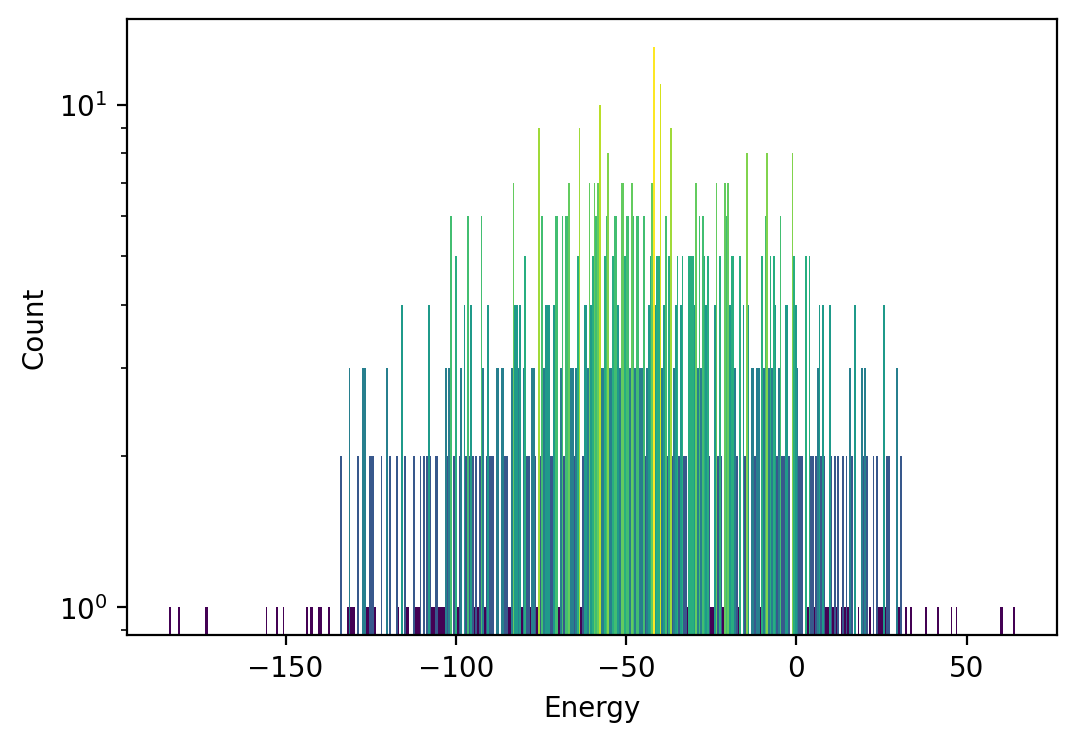

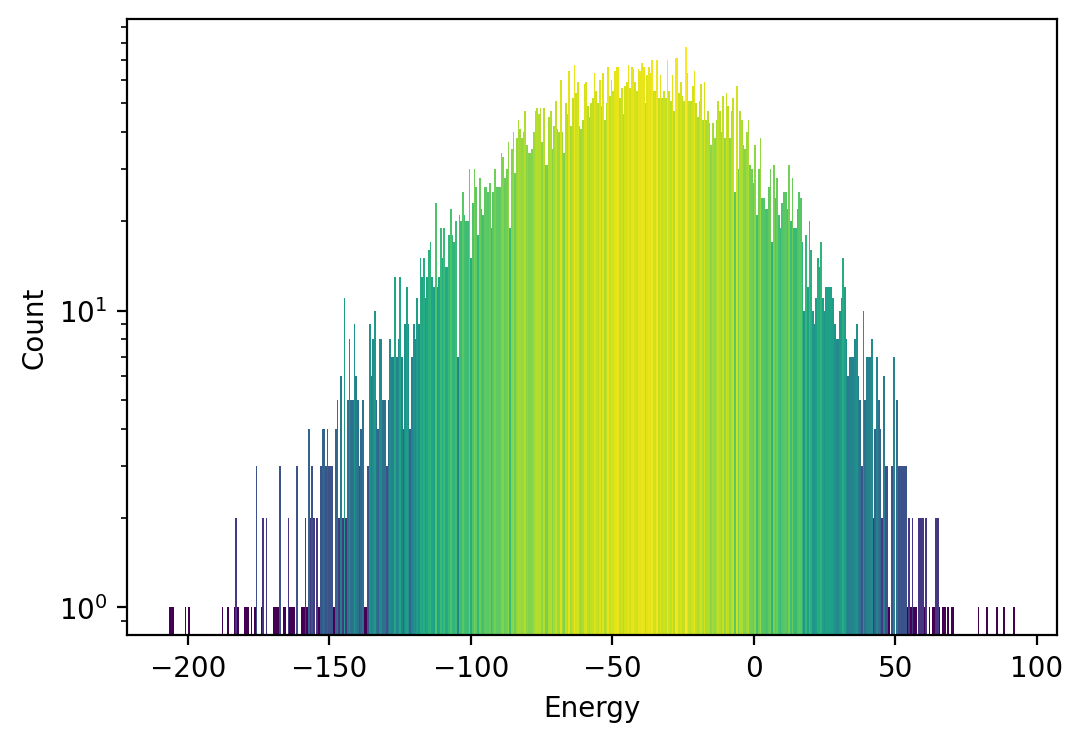

In [7]:
reads = [10, 100, 1000, 10000]

for r in reads:
    df = SteepestDescentSolver().sample(bqm, num_reads=r).to_pandas_dataframe(True)
    plotHistogram(df)

                                                sample      energy  \
297  {'Cello_10_blue': 1, 'Cello_10_green': 0, 'Cel... -207.807570   
800  {'Cello_10_blue': 1, 'Cello_10_green': 0, 'Cel... -179.960915   
309  {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -170.124197   
304  {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -168.937127   
249  {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -164.667882   

     num_occurrences  num_steps  
297                1        128  
800                1        142  
309                1        164  
304                1        148  
249                1        142  


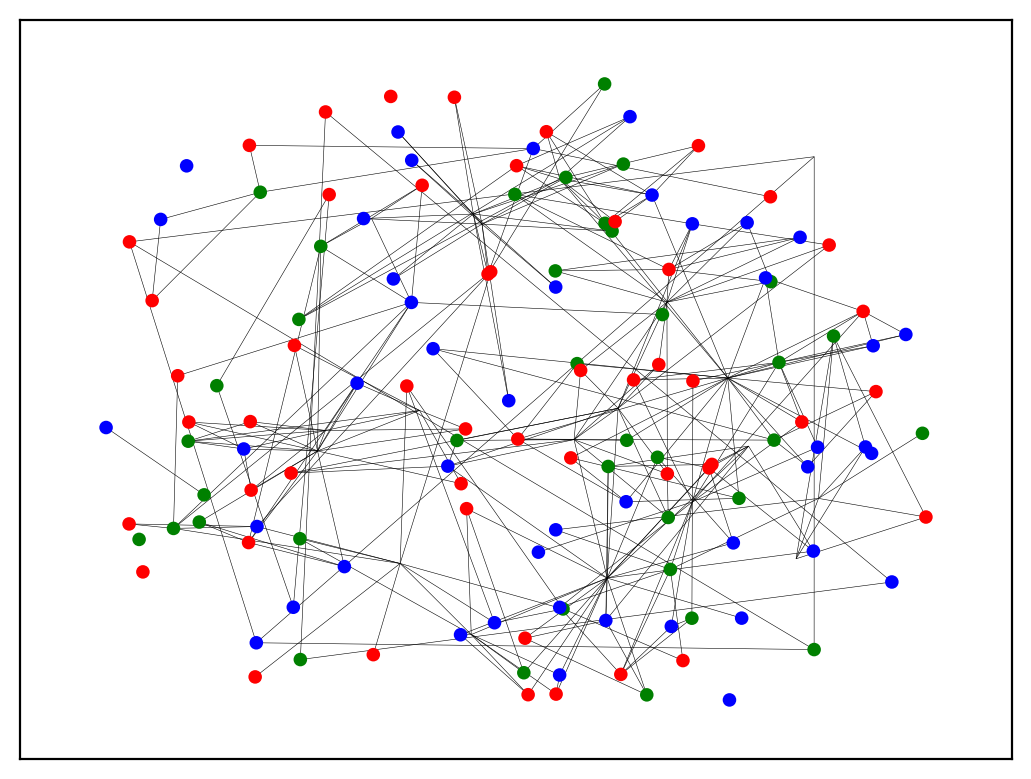

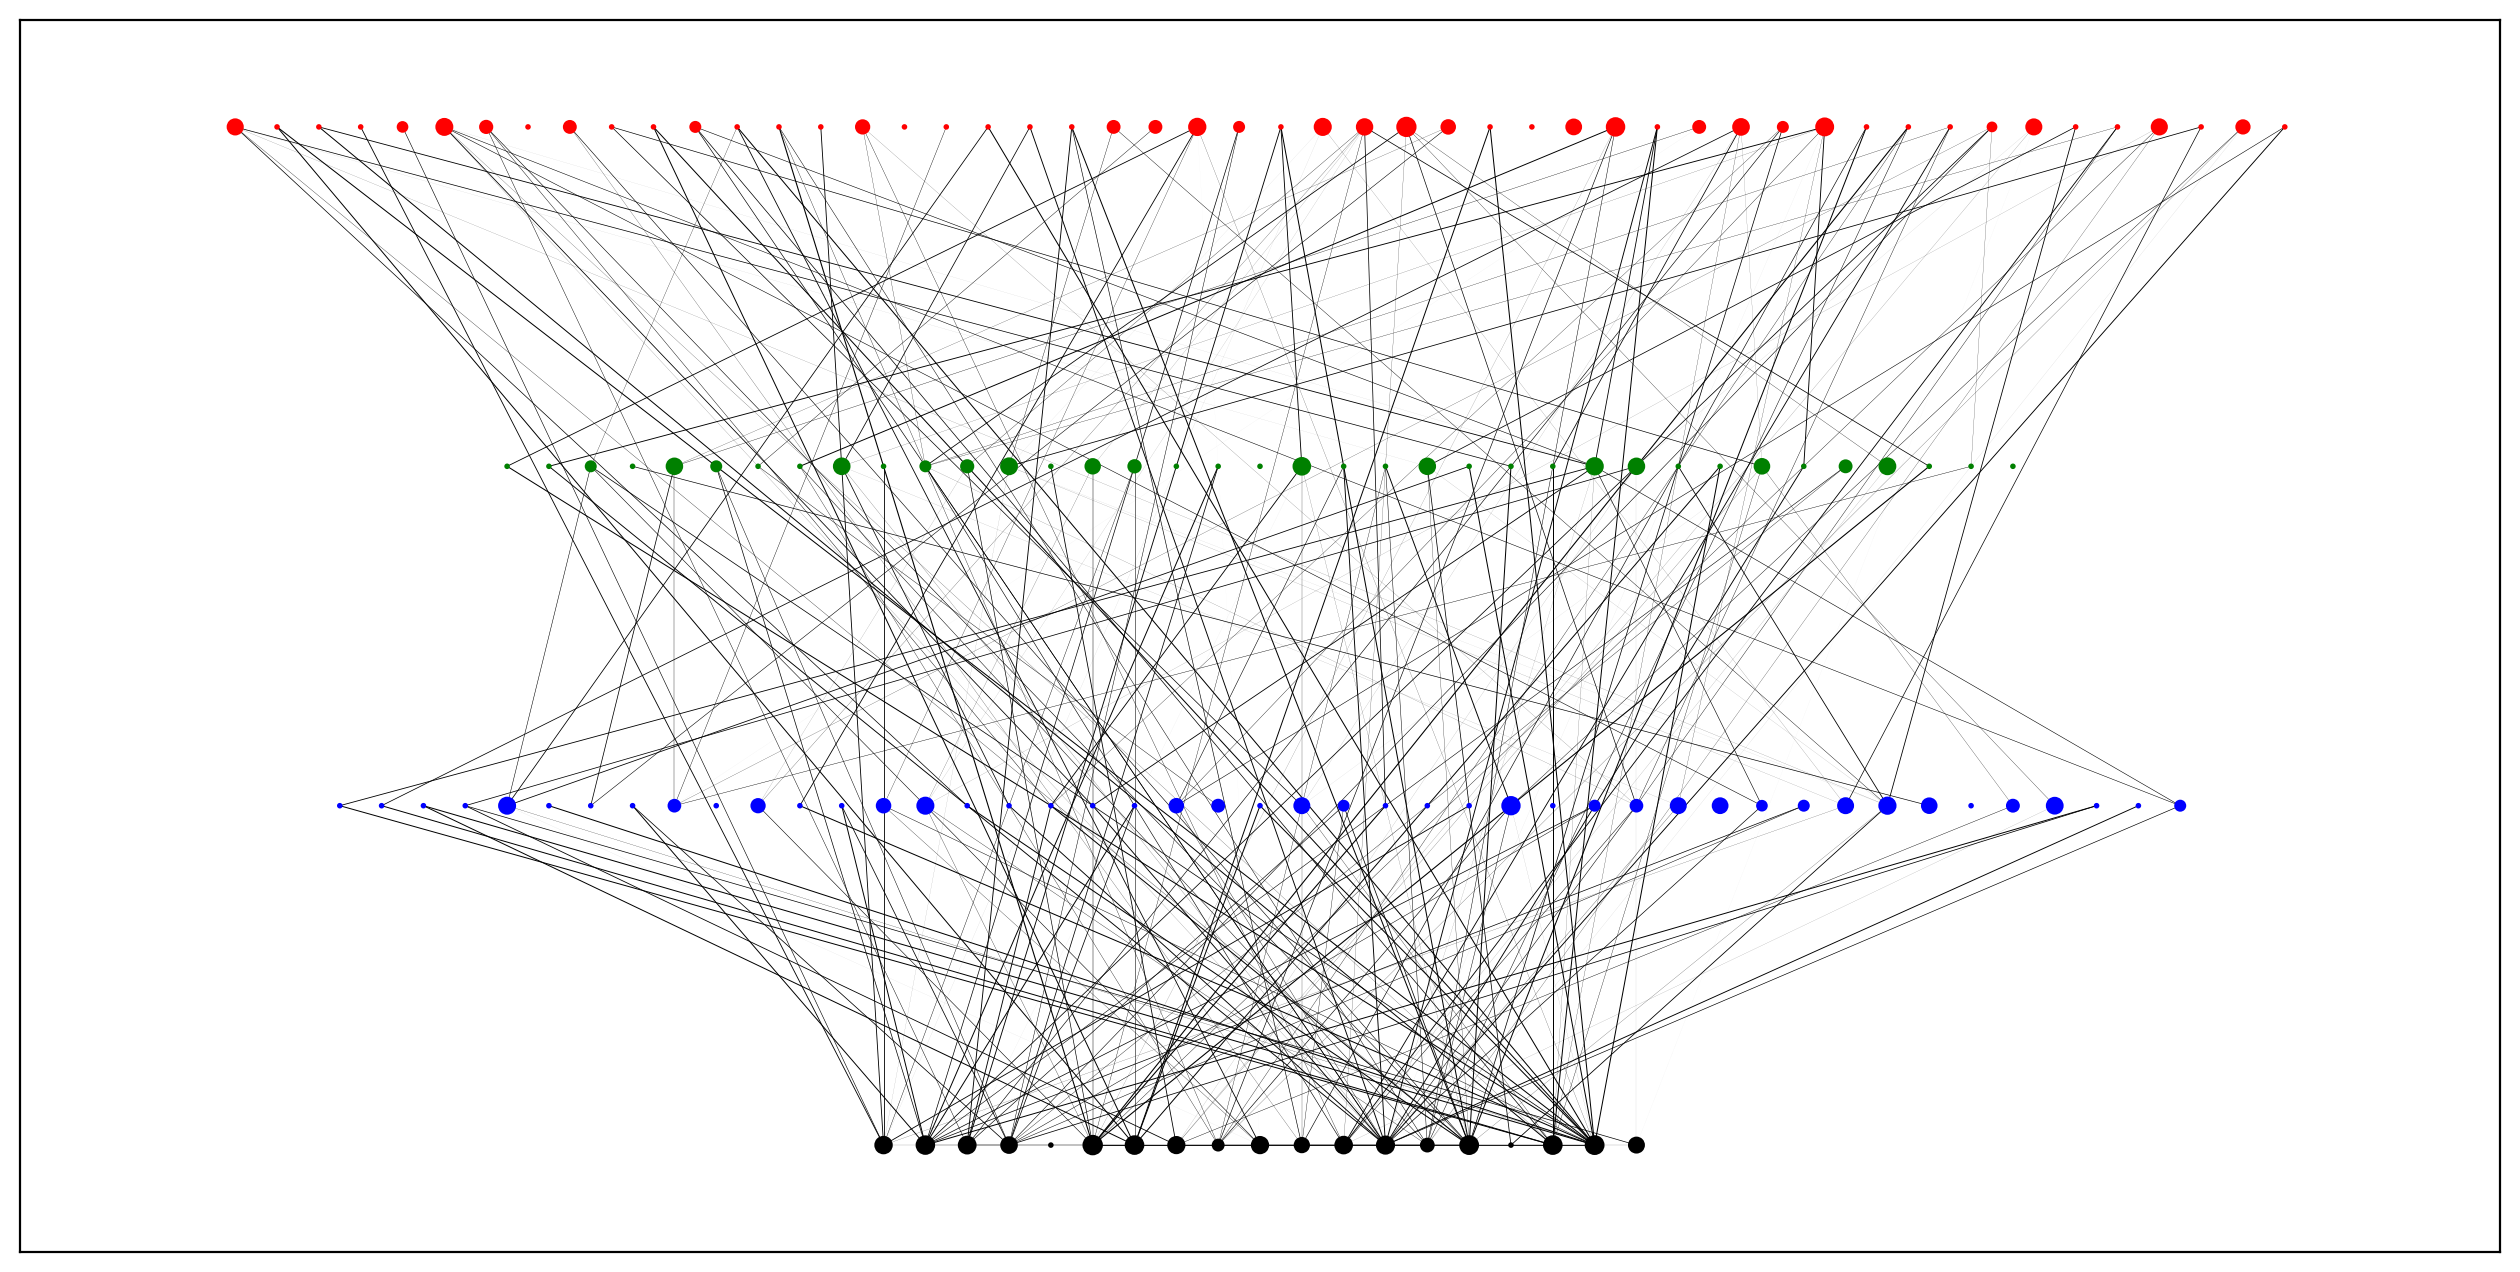

In [14]:
# Show results
def processNode(node):
    groups = re.match(r"(.*_\d+)_(\w+)", node).groups()
    return groups

#print(df.head())
print(df.sort_values("energy").head())

sample = df["sample"][0]
chosen = {processNode(x)[0]:processNode(x)[1] for x in sample if sample[x] == 1}

plt.figure(0)
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw_networkx_edges(G, pos, width=0.2)
nx.draw_networkx_nodes(G, pos, nodelist=chosen.keys(), node_color=chosen.values(), node_size=15)

plt.figure(2, figsize=(16,8))

for node in G.nodes():
    if node in chosen:
        G.nodes[node]["colour"] = chosen[node]
    else:
        G.nodes[node]["colour"] = "black"
pos = nx.multipartite_layout(G, "colour", "horizontal", 2)

nx.draw_networkx_nodes(G, pos, node_color=[G.nodes[node]["colour"] for node in G.nodes()], node_size=[10*(p.entropy+.1) for p in allPhrases])
nx.draw_networkx_edges(G, pos, width=[d["weight"]/10 for _, _, d in G.edges.data()])
#plt.savefig(f"../Figures/{identifier}_colouredGraph.pdf", pad_inches=0, bbox_inches="tight")

In [ ]:
# Solve on QPU

def solveWeightedMIS(G: nx.Graph, weights: list[tuple] = [], sampler=EmbeddingComposite(DWaveSampler()), num_reads: int = 100, strength_multiplier: float = 2) -> pd.DataFrame:
    bqm = dimod.generators.maximum_weight_independent_set(G.edges, weights, strength_multiplier=strength_multiplier)
    sampler = sampler
    sampleset = sampler.sample(bqm, num_reads = num_reads)
    return sampleset.to_pandas_dataframe(True)

df = solveWeightedMIS(G, phraseEntropies, num_reads=1000)

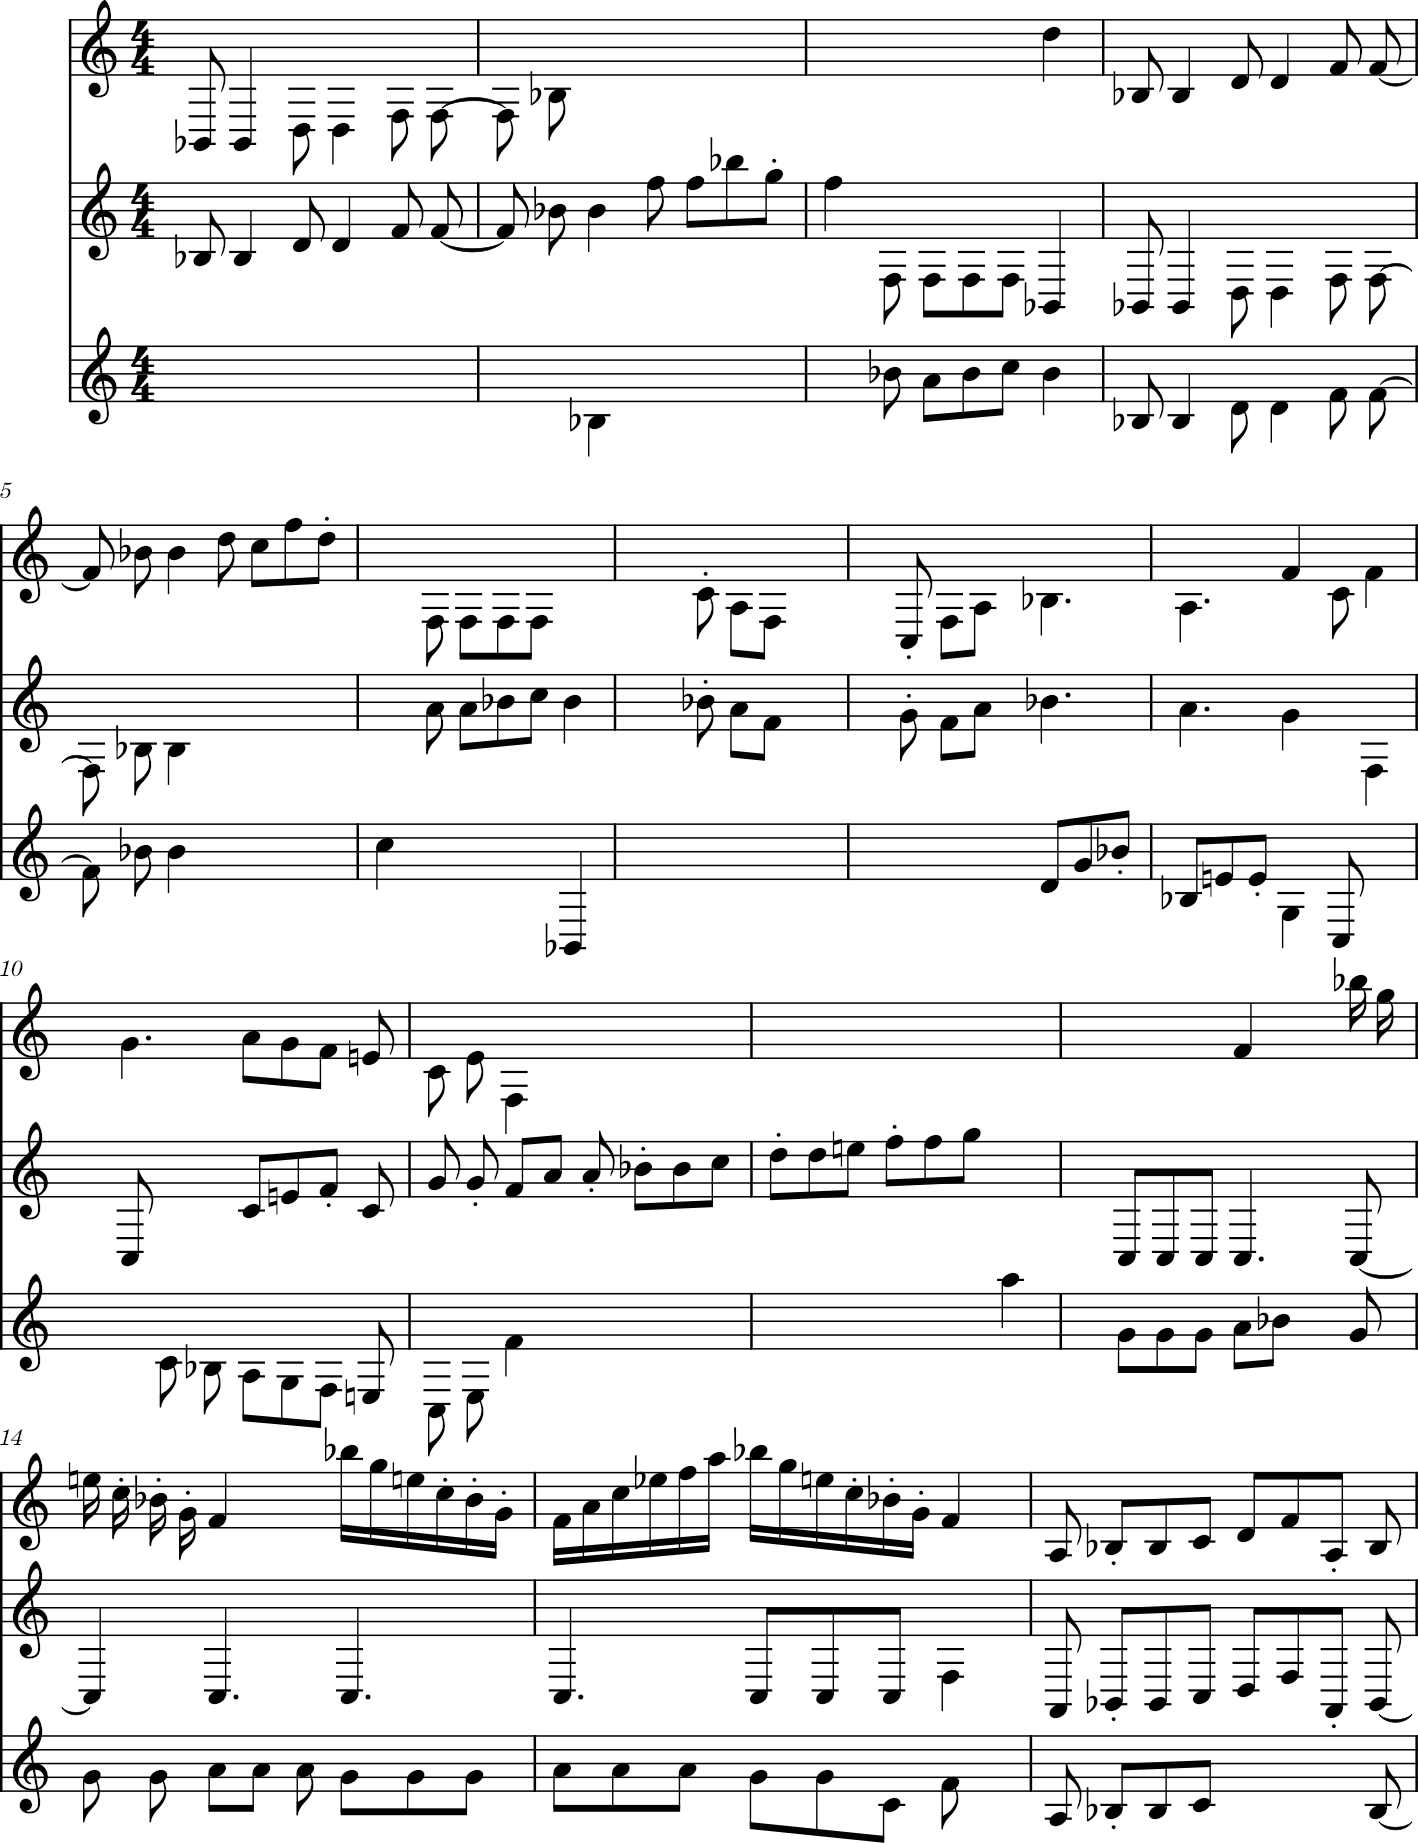

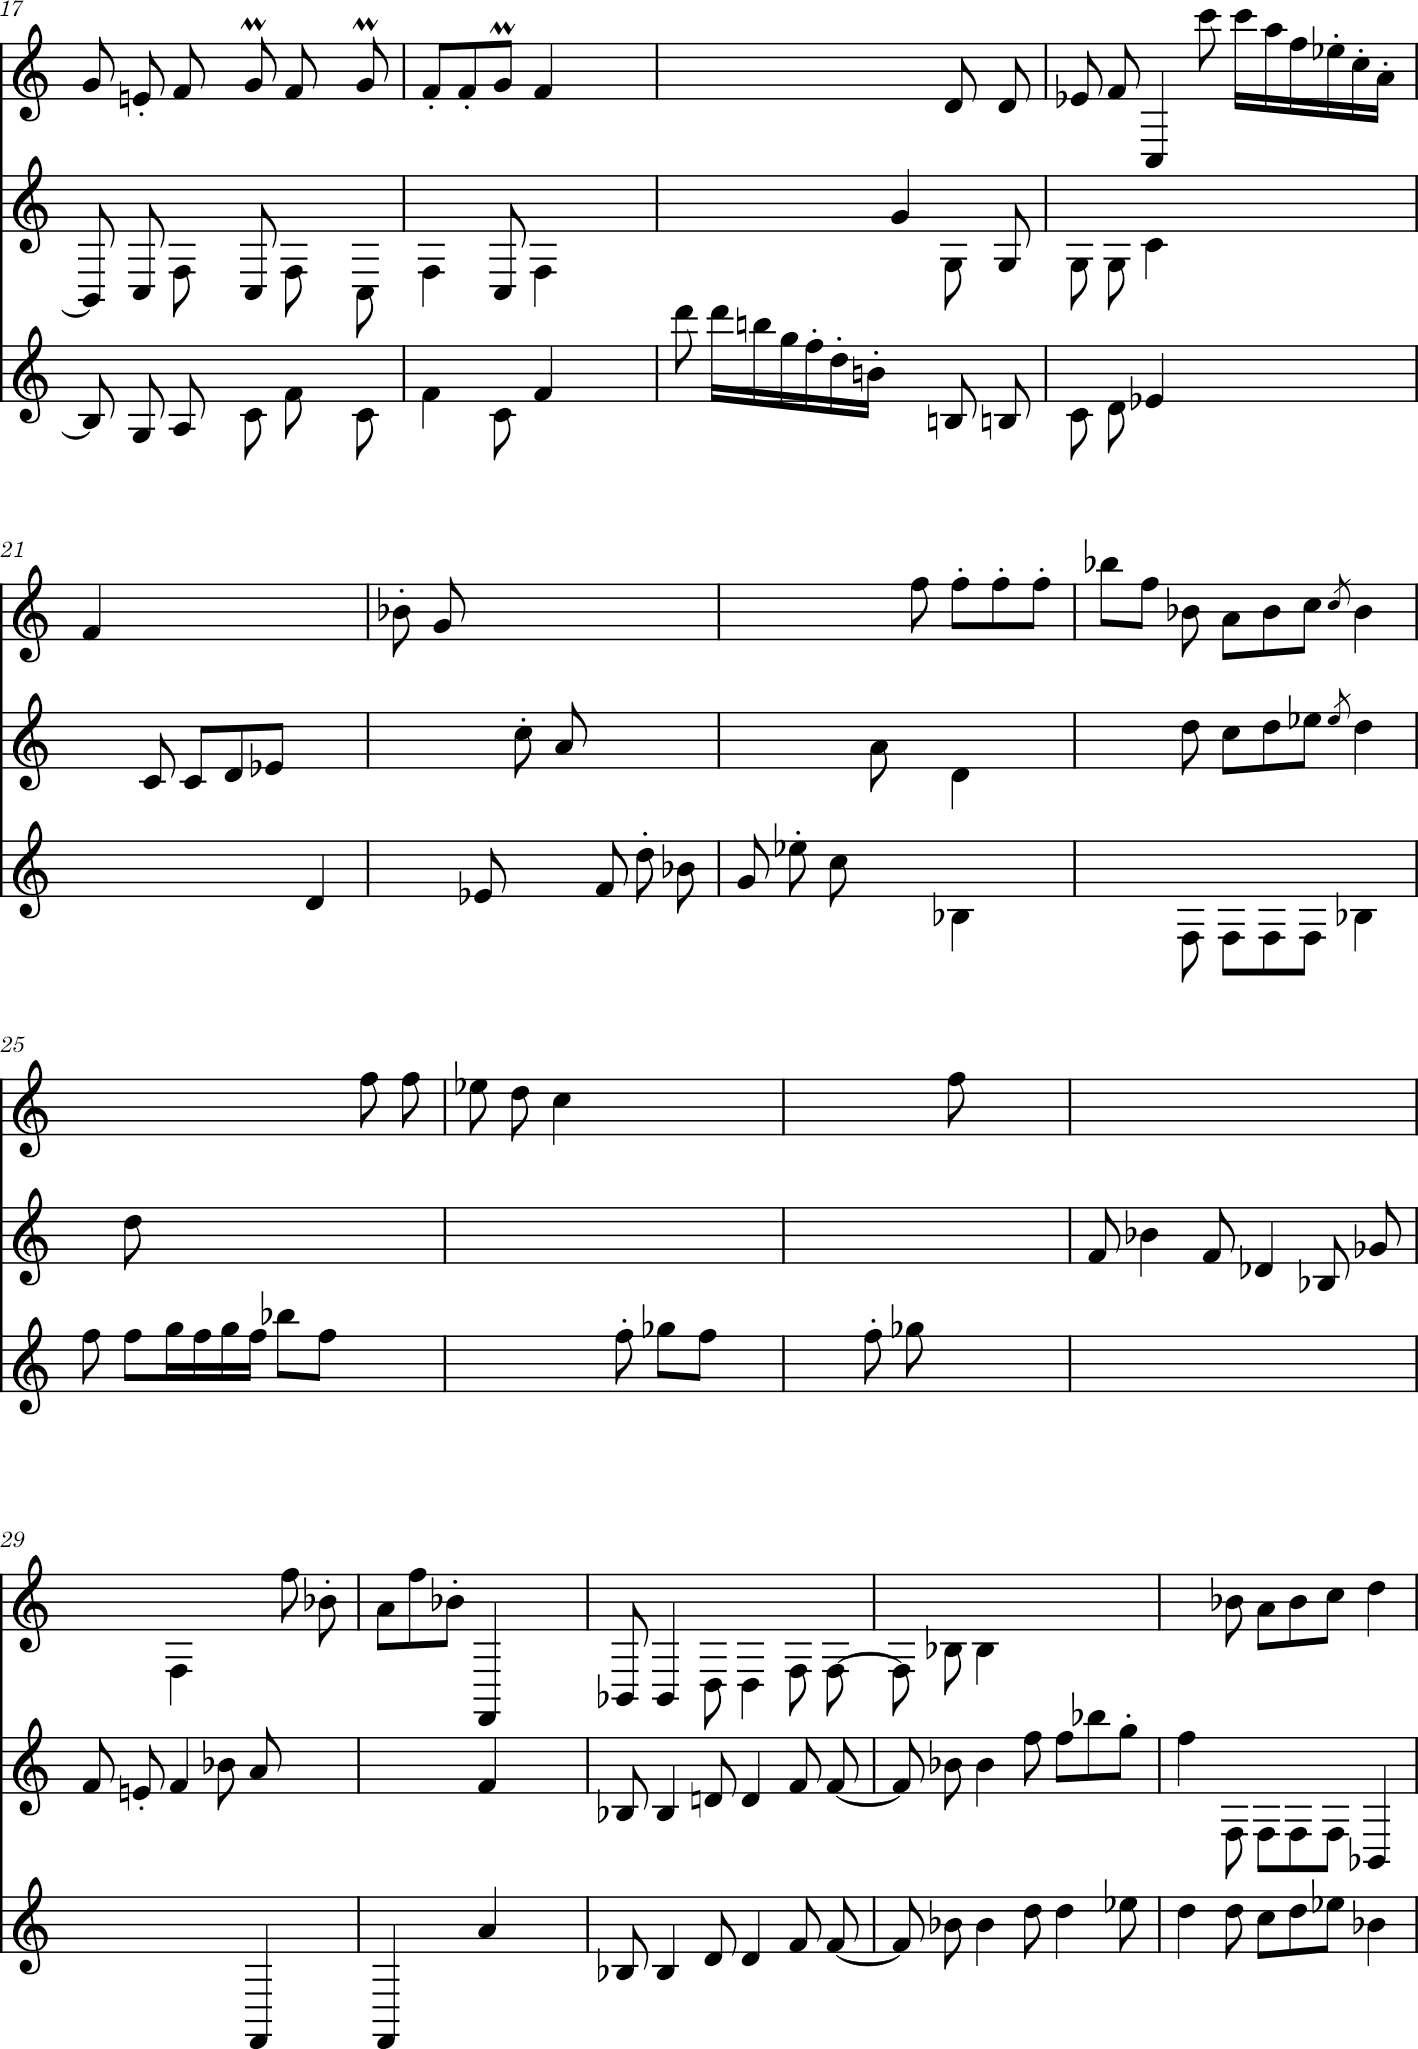

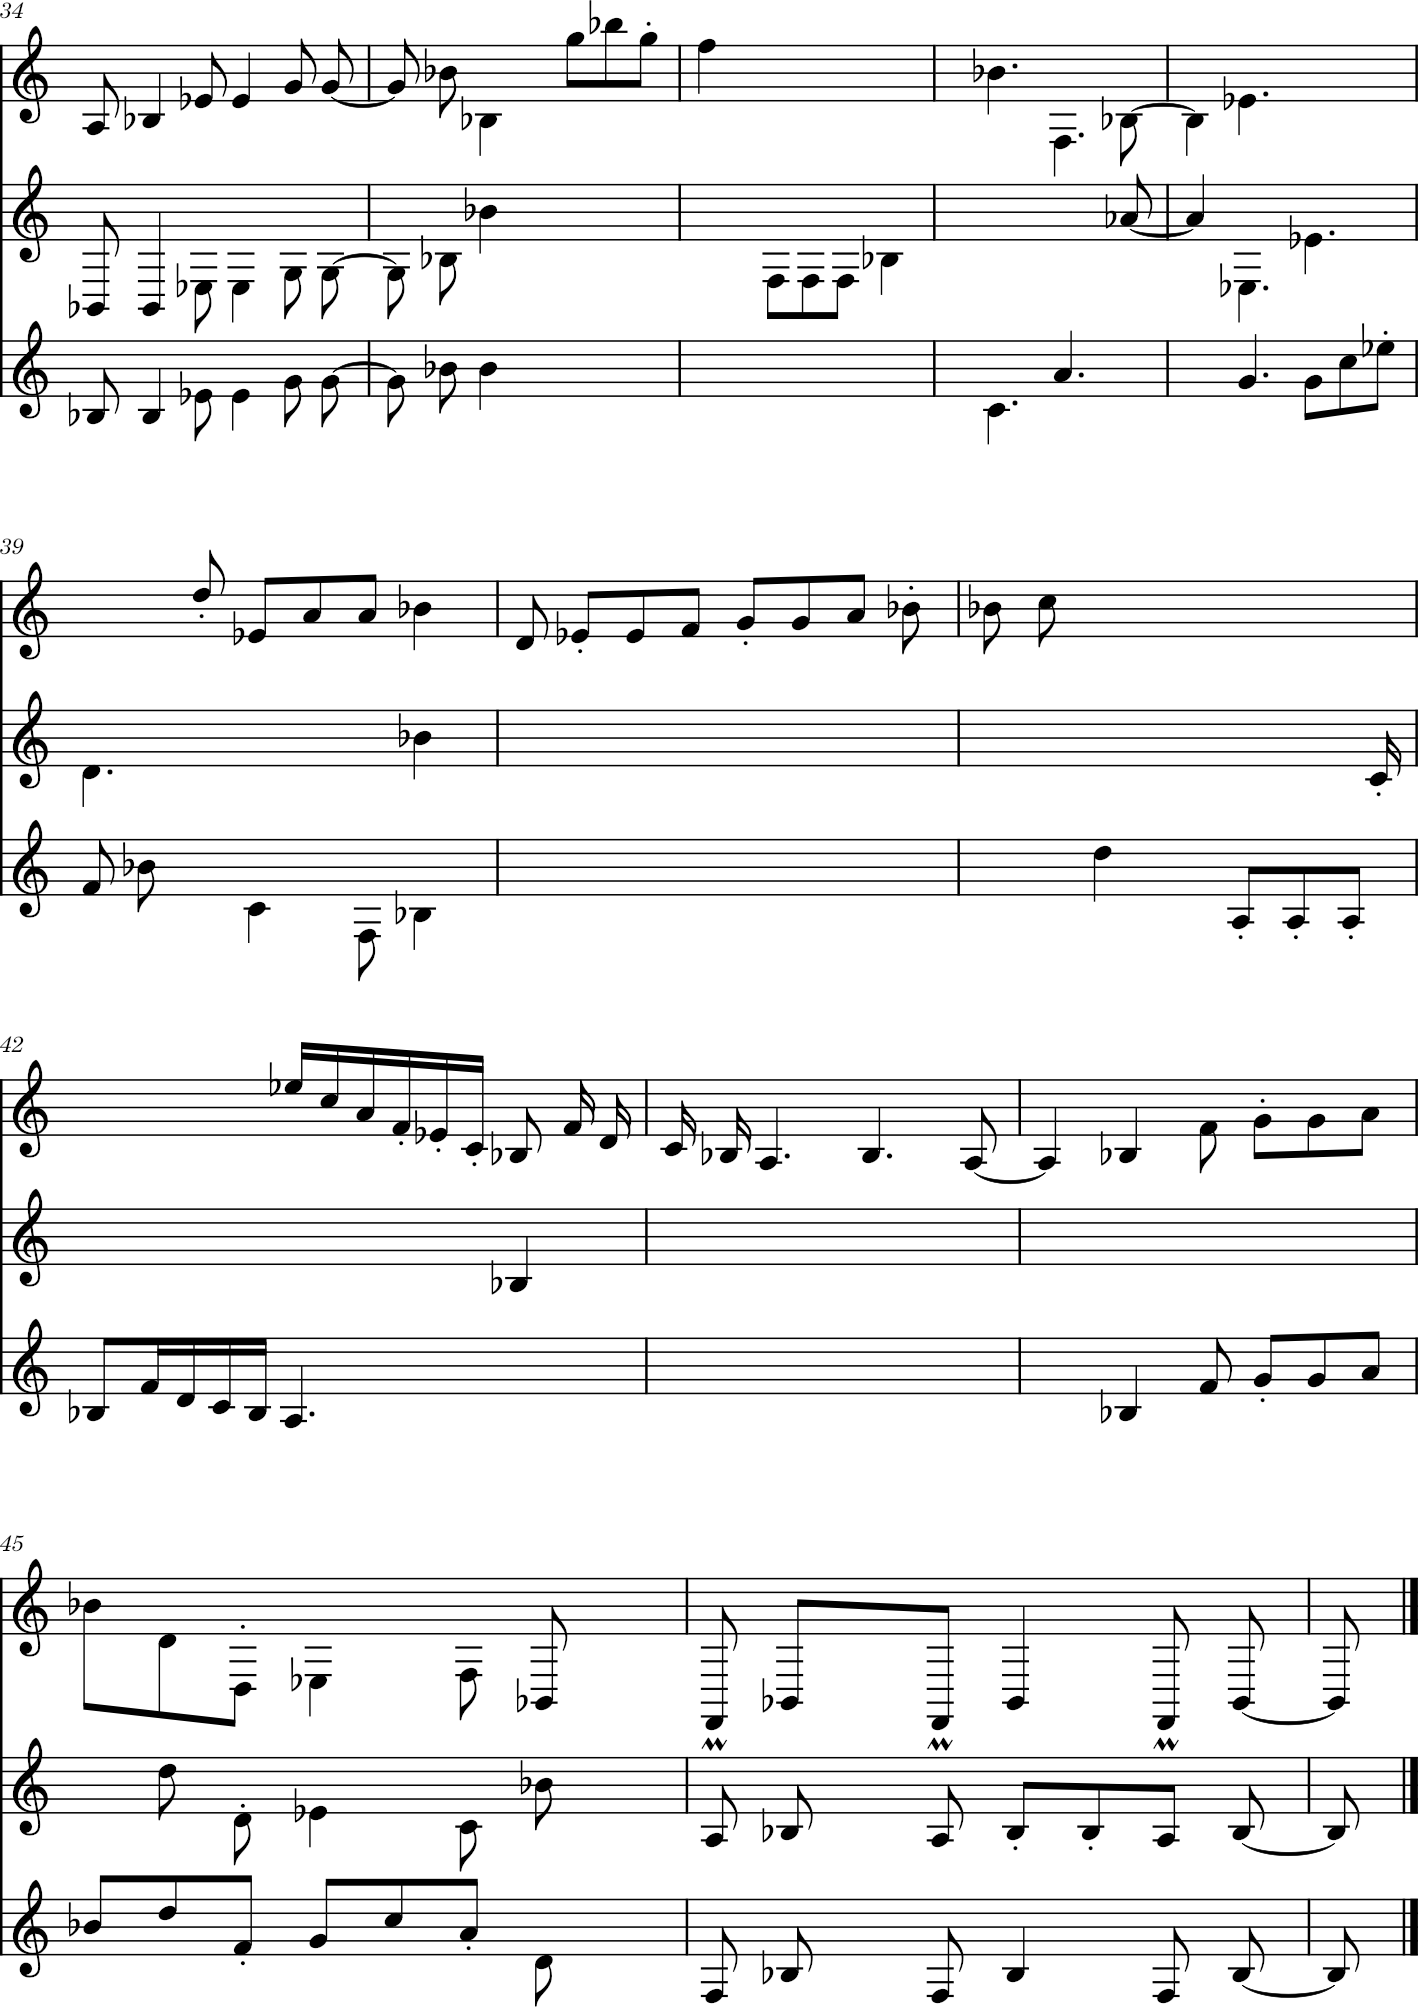

In [19]:
# Final arrangement

parts = {}
for col, inst in instruments.items():
    part = stream.Part()
    #part.append()
    parts[col] = part

for phrase in [phrase for part in phraseLists for phrase in part]:
    if phrase.id in chosen:
        parts[chosen[phrase.id]].mergeElements(phrase.notes.stream()) # Focus on JUST NOTES for now 

arrangement = stream.Score(parts.values())
arrangement.show("midi")
arrangement.show()

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# TODO: Allow specification of instrument for each part
# TODO: Bias selection of phrases to specific parts (e.g. by checking ambitus)
# TODO: Add meaningful edge weightings
# TODO: Find interesting constraints to add to BQM
# TODO: Are there more efficient ways to add constraints?